Shape of initial F_true: (20, 20, 9)


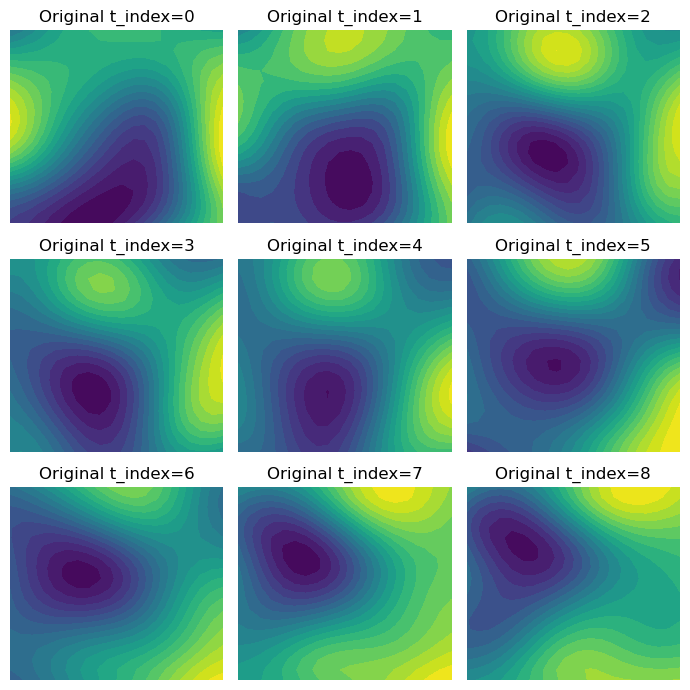

C:\Users\arche\AppData\Local\Temp\ipykernel_35468\3431233949.py:159: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  f_new_vec = np.random.multivariate_normal(mean=mu_new, cov=cov_new)


Shape of extended F: (20, 20, 9)


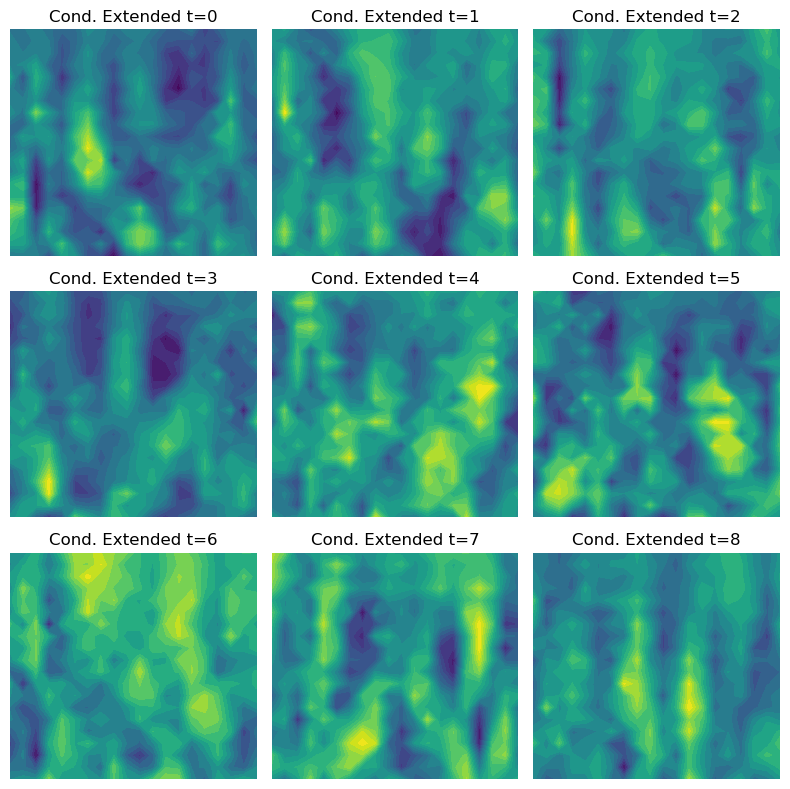

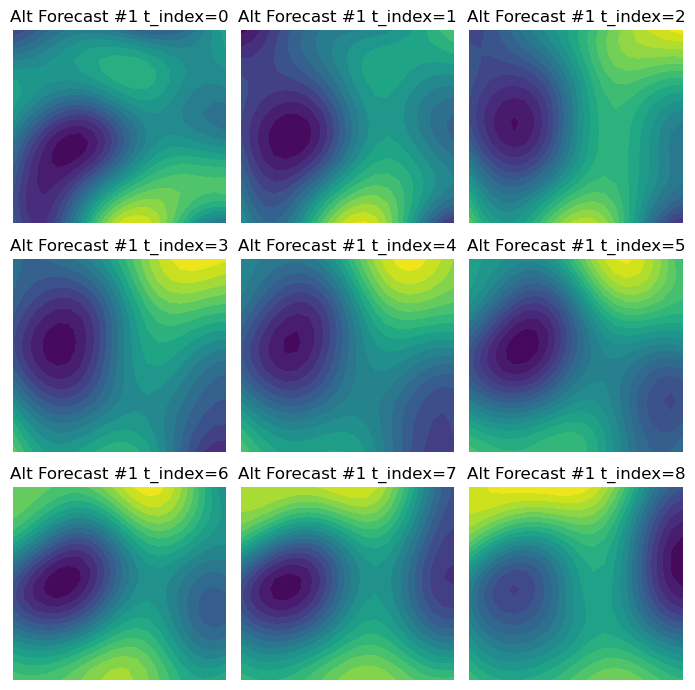

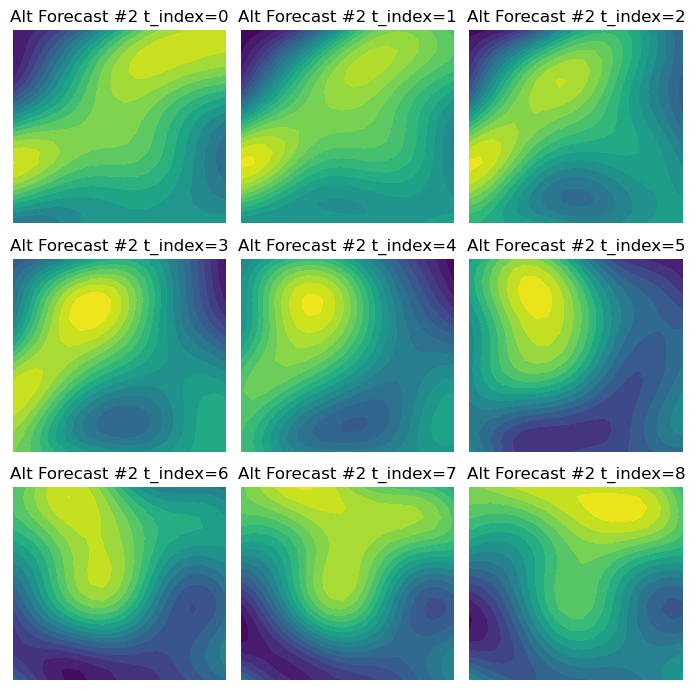

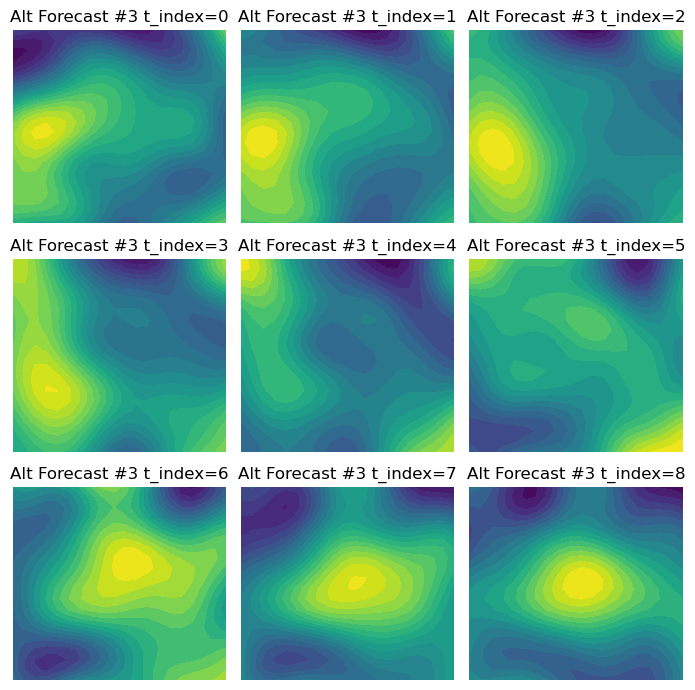

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from scipy.interpolate import RegularGridInterpolator

###############################################################################
# 1. Covariance Kernels
###############################################################################

def rbf_kernel_3d(coords1, coords2, length_scale=0.1, sigma=1.0):
    """
    Simple isotropic RBF kernel in 3D: k((x,y,t),(x',y',t')) = sigma^2 * exp(-||...||^2 / (2*ell^2))
    coords1 : (N, 3)
    coords2 : (M, 3)
    """
    diff = coords1[:, None, :] - coords2[None, :, :]  # shape (N,M,3)
    sqdist = np.sum(diff**2, axis=-1)                 # shape (N,M)
    K = sigma**2 * np.exp(-0.5 * sqdist / length_scale**2)
    return K

def product_rbf_kernel_spacetime(coords1, coords2,
                                 ls_space=0.1, sigma_space=1.0,
                                 ls_time=0.1, sigma_time=1.0):
    """
    Product kernel for spatio-temporal data:
        k((x,y,t),(x',y',t')) = k_space((x,y),(x',y')) * k_time(t,t')
    coords1 : (N, 3)
    coords2 : (M, 3)
    """
    # Separate out space (x,y) and time (t)
    xy1, t1 = coords1[:, :2], coords1[:, 2]
    xy2, t2 = coords2[:, :2], coords2[:, 2]

    # Space kernel
    diff_xy = xy1[:, None, :] - xy2[None, :, :]      # (N,M,2)
    sqdist_xy = np.sum(diff_xy**2, axis=-1)          # (N,M)
    K_space = sigma_space**2 * np.exp(-0.5 * sqdist_xy / ls_space**2)

    # Time kernel
    diff_t = t1[:, None] - t2[None, :]
    sqdist_t = diff_t**2
    K_time = sigma_time**2 * np.exp(-0.5 * sqdist_t / ls_time**2)

    return K_space * K_time

###############################################################################
# 2. Generating Spatio-Temporal GP Data
###############################################################################

def generate_gp_st(nx=20, ny=20, nt=9, kernel="3d_rbf",
                   ls_space=0.05, sigma_space=1.0,
                   ls_time=0.2, sigma_time=1.0,
                   random_state=None):
    """
    Generate spatio-temporal data of shape (nx, ny, nt).
    Domain: x in [0,1], y in [0,1], t in [0,1].
    kernel: "3d_rbf" or "product"
    """
    if random_state is not None:
        np.random.seed(random_state)

    X = np.linspace(0, 1, nx)
    Y = np.linspace(0, 1, ny)
    T = np.linspace(0, 1, nt)

    # Create meshgrid, then flatten to (N,3)
    Xv, Yv, Tv = np.meshgrid(X, Y, T, indexing='ij')  # shape (nx,ny,nt)
    coords = np.column_stack((Xv.ravel(), Yv.ravel(), Tv.ravel()))  # shape (N,3)
    N = coords.shape[0]

    # Build covariance matrix
    if kernel == "3d_rbf":
        # Single 3D isotropic RBF
        K = rbf_kernel_3d(coords, coords,
                          length_scale=ls_space,  # ignoring separate scales
                          sigma=sigma_space)
    else:
        # Product kernel: separate space/time length scales
        K = product_rbf_kernel_spacetime(coords, coords,
                                         ls_space=ls_space, sigma_space=sigma_space,
                                         ls_time=ls_time, sigma_time=sigma_time)

    # Sample from MVN(0,K)
    F_vec = np.random.multivariate_normal(mean=np.zeros(N), cov=K)
    F = F_vec.reshape((nx, ny, nt))  # reshape back

    return X, Y, T, F

###############################################################################
# 3. Conditional Extension: 9 --> 18 Time Steps
###############################################################################

def conditional_extend_st(X, Y, T_old, F_old, nt_new=18, kernel_params=None):
    """
    Extend spatio-temporal data from shape (nx,ny,nt_old) to (nx,ny,nt_new)
    using the SAME GP kernel parameters, ensuring the old data is consistent.

    The domain [0,1] in time is extended but we keep T_old and T_new in [0,1].
    We do a conditional GP approach:
        f_new | f_old ~ N( K_new_old * K_old_old^-1 * f_old,
                           K_new_new - K_new_old * K_old_old^-1 * K_old_new )
    kernel_params: dict with keys for "ls_space", "sigma_space", "ls_time", "sigma_time", "kernel"
    """
    # We'll assume we want the same spatial grid (X,Y), but more time points.
    nt_old = F_old.shape[2]
    nx, ny = F_old.shape[0], F_old.shape[1]

    # Build new time array
    T_new = np.linspace(0, 1, nt_new)
    # Combine old+new times into one set for coordinate building
    T_all = np.concatenate([T_old, T_new])

    # Flatten coords
    Xv, Yv, Tv_old = np.meshgrid(X, Y, T_old, indexing='ij')
    coords_old = np.column_stack((Xv.ravel(), Yv.ravel(), Tv_old.ravel()))
    Xv2, Yv2, Tv_new = np.meshgrid(X, Y, T_new, indexing='ij')
    coords_new = np.column_stack((Xv2.ravel(), Yv2.ravel(), Tv_new.ravel()))

    # We already have f_old as shape (nx,ny,nt_old), flatten it
    f_old_vec = F_old.ravel()

    # dict(kernel="product", ls_space=0.3, sigma_space=1.0,
    #                      ls_time=0.2,  sigma_time=0.9)
    # Covariance sub-blocks:
    if kernel_params is None:
        kernel_params = dict(kernel="product",
                             ls_space=0.05, sigma_space=1.0,
                             ls_time=0.2,  sigma_time=1.0)

    # Build the kernel function
    if kernel_params["kernel"] == "3d_rbf":
        def K_fn(a,b):
            return rbf_kernel_3d(a, b,
                                 length_scale=kernel_params["ls_space"],
                                 sigma=kernel_params["sigma_space"])
    else:
        def K_fn(a,b):
            return product_rbf_kernel_spacetime(a,b,
                            ls_space=kernel_params["ls_space"],
                            sigma_space=kernel_params["sigma_space"],
                            ls_time=kernel_params["ls_time"],
                            sigma_time=kernel_params["sigma_time"])

    K_old_old = K_fn(coords_old, coords_old)  # shape (Nold, Nold)
    K_old_new = K_fn(coords_old, coords_new)  # (Nold, Nnew)
    K_new_old = K_fn(coords_new, coords_old)  # (Nnew, Nold)
    K_new_new = K_fn(coords_new, coords_new)  # (Nnew, Nnew)

    # Invert K_old_old (may be large, be mindful of memory!)
    K_old_old_inv = np.linalg.inv(K_old_old)

    # Mean of conditional
    mu_new = K_new_old @ K_old_old_inv @ f_old_vec

    # Cov of conditional
    cov_new = K_new_new - K_new_old @ K_old_old_inv @ K_old_new

    # Sample
    f_new_vec = np.random.multivariate_normal(mean=mu_new, cov=cov_new)
    F_new_block = f_new_vec.reshape((nx, ny, nt_new))

    # We keep the old portion for t in T_old exactly,
    # so let's build one final F with shape (nx, ny, nt_new):
    # But note: T_new is not necessarily strictly beyond T_old in numeric sense
    # This code just uses the new block for all times T_new
    return X, Y, T_new, F_new_block

###############################################################################
# 4. Multiple Forecasts from the Same (nx,ny,nt)
###############################################################################

def generate_alternate_forecasts_from_old(X, Y, T, F_old, alt_params_list):
    """
    Suppose we have an 'observed' portion F_old of shape (nx,ny,nt).
    We want to create multiple 'forecast' fields from time steps beyond T[-1],
    but each with different kernel parameters.

    For simplicity, we generate new data from t in [T[-1], 2*T[-1]] or so,
    and then combine with F_old. Or we can do it in [0,1] again, but let's
    keep it conceptually separate.
    """
    # This is a conceptual demonstration. We'll just re-use the domain in a naive way
    # to show how to produce variety of forecasts. In real code, you'd do partial
    # condition or re-sample from new kernel for future times only.

    forecasts = []
    for i, params in enumerate(alt_params_list):
        # For demonstration, let's just generate a brand new (nx,ny,nt) with the new params
        # ignoring continuity. Realistically you'd do partial condition if you want continuity.
        _, _, T_new, F_new = generate_gp_st(nx=F_old.shape[0],
                                            ny=F_old.shape[1],
                                            nt=F_old.shape[2],
                                            kernel=params["kernel"],
                                            ls_space=params.get("ls_space",0.05),
                                            sigma_space=params.get("sigma_space",1.0),
                                            ls_time=params.get("ls_time",0.2),
                                            sigma_time=params.get("sigma_time",1.0),
                                            random_state=params.get("random_state",None))
        forecasts.append(F_new)
    return forecasts

###############################################################################
# 5. Visualization
###############################################################################

def plot_time_slices(X, Y, F, title_prefix=""):
    """
    Plot each time slice in a 3x3 grid (assuming F has shape (nx,ny,9) or so).
    """
    nx, ny, nt = F.shape
    nrows = int(np.ceil(nt/3))
    plt.figure(figsize=(7,7))
    for i in range(nt):
        plt.subplot(nrows,3,i+1)
        plt.contourf(X, Y, F[:,:,i], levels=20, cmap='viridis')
        plt.title(f"{title_prefix} t_index={i}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

###############################################################################
# Main Demo
###############################################################################

if __name__ == "__main__":
    # ==========================================================================
    # A) Generate 20x20x9 data via product kernel
    # ==========================================================================
    X, Y, T, F_true = generate_gp_st(
        nx=20, ny=20, nt=9,
        kernel="product",
        ls_space=0.3, sigma_space=1.0,
        ls_time=0.2,  sigma_time=0.9,
        random_state=42
    )

    print("Shape of initial F_true:", F_true.shape)  # (20,20,9)

    # Visualize all 9 time slices
    plot_time_slices(X, Y, F_true, title_prefix="Original")

    # ==========================================================================
    # B) Extend from 9 -> 18 time steps using the SAME GP parameters (conditional)
    # ==========================================================================
    kernel_params = dict(kernel="product", ls_space=0.3, sigma_space=1.0,
                         ls_time=0.2,  sigma_time=0.9)

    X2, Y2, T2, F_extended = conditional_extend_st(
        X, Y, T, F_true,
        nt_new=9,  # now want 18 time slices
        kernel_params=kernel_params
    )

    print("Shape of extended F:", F_extended.shape)  # (20,20,18)

    # Let's visualize the first 9 slices (which should be consistent with the old data)
    # plus the new slices.
    # We'll just plot all 18:
    nplots = F_extended.shape[2]
    nrows = int(np.ceil(nplots/3))
    plt.figure(figsize=(8,8))
    for i in range(nplots):
        plt.subplot(nrows,3,i+1)
        plt.contourf(X2, Y2, F_extended[:,:,i], levels=20, cmap='viridis')
        plt.title(f"Cond. Extended t={i}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

    # ==========================================================================
    # C) Generate multiple "forecasts" from the same 9-step data
    #    but different kernel parameters (scenario testing).
    #    (This is not a single consistent GP across time,
    #     but can be used to see different correlation assumptions.)
    # ==========================================================================
    alt_params_list = [
        {"kernel":"product", "ls_space":0.3, "sigma_space":1.0, "ls_time":0.3, "sigma_time":0.9, "random_state":101},
        {"kernel":"product", "ls_space":0.3,  "sigma_space":2.0, "ls_time":0.3, "sigma_time":0.5, "random_state":202},
        {"kernel":"3d_rbf",  "ls_space":0.2, "sigma_space":1.0,  "random_state":303}
    ]
    forecasts = generate_alternate_forecasts_from_old(X, Y, T, F_true, alt_params_list)

    # Let's just plot the first forecast
    plot_time_slices(X, Y, forecasts[0], title_prefix="Alt Forecast #1")

    # And plot the second forecast
    plot_time_slices(X, Y, forecasts[1], title_prefix="Alt Forecast #2")

    # Plot the third
    plot_time_slices(X, Y, forecasts[2], title_prefix="Alt Forecast #3")

    # Done!


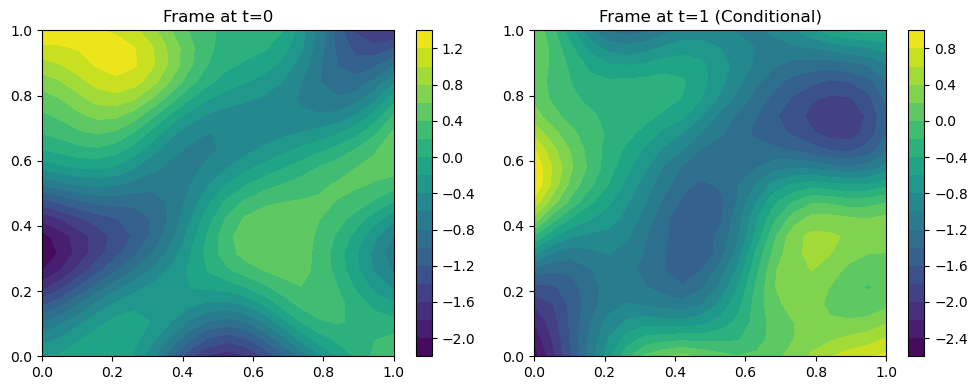

In [27]:
import numpy as np
import matplotlib.pyplot as plt

###############################################################################
# 1. Kernel Definitions
###############################################################################

def rbf_space_kernel(xy1, xy2, ls_space=0.1, sigma_space=1.0):
    """
    2D RBF kernel in (x,y).
    xy1: shape (N, 2)
    xy2: shape (M, 2)
    Returns: (N, M) covariance
    """
    diff = xy1[:, None, :] - xy2[None, :, :]  # (N,M,2)
    dist_sq = np.sum(diff**2, axis=-1)        # (N,M)
    K = sigma_space**2 * np.exp(-0.5 * dist_sq / ls_space**2)
    return K

def rbf_time_kernel(t1, t2, ls_time=0.5, sigma_time=1.0):
    """
    1D RBF kernel in time dimension.
    t1: shape (N,)
    t2: shape (M,)
    Returns: (N, M) covariance
    """
    diff_t = t1[:, None] - t2[None, :]
    dist_sq_t = diff_t**2
    K = sigma_time**2 * np.exp(-0.5 * dist_sq_t / ls_time**2)
    return K

def product_spacetime_kernel(coords1, coords2,
                             ls_space=0.1, sigma_space=1.0,
                             ls_time=0.5, sigma_time=1.0):
    """
    Product kernel in (x,y) x t:
      k((x,y,t), (x',y',t')) = k_space((x,y),(x',y')) * k_time(t,t').
    coords1: (N, 3) = [x,y,t]
    coords2: (M, 3) = [x',y',t']
    """
    # Separate out space vs. time
    xy1, t1 = coords1[:, :2], coords1[:, 2]
    xy2, t2 = coords2[:, :2], coords2[:, 2]

    K_space = rbf_space_kernel(xy1, xy2, ls_space=ls_space, sigma_space=sigma_space)
    K_time  = rbf_time_kernel(t1, t2, ls_time=ls_time, sigma_time=sigma_time)

    return K_space * K_time

###############################################################################
# 2. Generate a Single Frame for t=0 (Unconditional Sample)
###############################################################################

def sample_frame_t0(nx=20, ny=20,
                    ls_space=0.1, sigma_space=1.0,
                    ls_time=0.5, sigma_time=1.0,
                    random_state=123):
    """
    Generate a single spatio-temporal GP sample for t=0
    (which is effectively a 2D GP in x,y, but we attach t=0 in the coords).
    Returns:
      X, Y, F0 with shape (nx, ny).
    """
    if random_state is not None:
        np.random.seed(random_state)

    X = np.linspace(0, 1, nx)
    Y = np.linspace(0, 1, ny)

    # Build coords for t=0
    Xv, Yv = np.meshgrid(X, Y, indexing='ij')  # (nx, ny)
    coords_old = np.column_stack((Xv.ravel(), Yv.ravel(), np.zeros(nx*ny)))  # (nx*ny, 3)

    # Covariance among these points (the "old" slice)
    K_old = product_spacetime_kernel(coords_old, coords_old,
                                     ls_space=ls_space, sigma_space=sigma_space,
                                     ls_time=ls_time, sigma_time=sigma_time)
    # Sample from MVN(0, K_old)
    f_old = np.random.multivariate_normal(mean=np.zeros(nx*ny), cov=K_old)
    F0 = f_old.reshape((nx, ny))
    return X, Y, F0

###############################################################################
# 3. Condition to get Next Frame t=1
###############################################################################

def sample_frame_t1_given_t0(X, Y, F0,
                             ls_space=0.1, sigma_space=1.0,
                             ls_time=0.5, sigma_time=1.0,
                             random_state=999):
    """
    Given an existing frame F0 at t=0, generate a correlated next frame F1 at t=1
    by conditioning on F0 in the same spatio-temporal GP.

    Returns F1 of shape (nx, ny).
    """
    if random_state is not None:
        np.random.seed(random_state)

    nx, ny = F0.shape
    # Build coords for old (t=0) and new (t=1)
    Xv, Yv = np.meshgrid(X, Y, indexing='ij')
    coords_old = np.column_stack((Xv.ravel(), Yv.ravel(), np.zeros(nx*ny)))  # (N,3)
    coords_new = np.column_stack((Xv.ravel(), Yv.ravel(), np.ones(nx*ny)))   # (N,3)

    # Flatten old data
    f_old_vec = F0.ravel()

    # Covariance blocks
    K_old_old = product_spacetime_kernel(coords_old, coords_old,
                                         ls_space=ls_space, sigma_space=sigma_space,
                                         ls_time=ls_time, sigma_time=sigma_time)
    K_old_new = product_spacetime_kernel(coords_old, coords_new,
                                         ls_space=ls_space, sigma_space=sigma_space,
                                         ls_time=ls_time, sigma_time=sigma_time)
    K_new_old = product_spacetime_kernel(coords_new, coords_old,
                                         ls_space=ls_space, sigma_space=sigma_space,
                                         ls_time=ls_time, sigma_time=sigma_time)
    K_new_new = product_spacetime_kernel(coords_new, coords_new,
                                         ls_space=ls_space, sigma_space=sigma_space,
                                         ls_time=ls_time, sigma_time=sigma_time)

    # Invert the old covariance
    K_old_old_inv = np.linalg.inv(K_old_old)

    # Conditional mean
    mu_new = K_new_old @ K_old_old_inv @ f_old_vec

    # Conditional covariance
    cov_new = K_new_new - K_new_old @ K_old_old_inv @ K_old_new
    cov_new = 0.5 * (cov_new + cov_new.T)
    epsilon = 1e-6  # or 1e-8, 1e-6, etc. - tune as needed
    cov_new_regularized = cov_new + epsilon * np.eye(cov_new.shape[0])
    f_new_vec = np.random.multivariate_normal(mean=mu_new, cov=cov_new_regularized)

    F1 = f_new_vec.reshape((nx, ny))
    return F1

###############################################################################
# Demo
###############################################################################

if __name__ == "__main__":
    # 1) Generate initial frame at t=0
    X, Y, F0 = sample_frame_t0(nx=20, ny=20,
                               ls_space=0.2, sigma_space=1.0,
                               ls_time=0.3, sigma_time=.9,
                               random_state=42)
    # 2) Condition to get next frame at t=1
    F1 = sample_frame_t1_given_t0(X, Y, F0,
                                  ls_space=0.2, sigma_space=1.0,
                                  ls_time=0.3, sigma_time=.9,
                                  random_state=3)

    # Plot the two frames
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.contourf(X, Y, F0, levels=20, cmap='viridis')
    plt.title("Frame at t=0")
    plt.colorbar()

    plt.subplot(1,2,2)
    plt.contourf(X, Y, F1, levels=20, cmap='viridis')
    plt.title("Frame at t=1 (Conditional)")
    plt.colorbar()

    plt.tight_layout()
    plt.show()

    # Optional: see how "similar" or "different" the frames are
    # if the time length scale is large (ls_time=0.5), F1 should look
    # correlated with F0, but not identical.
